#A summary on Thompson Sampling

With multiple reference from "A Tutorial on Thompson Sampling". Experiments will follow this summary.

##Advantages of Thompson Sampling

Thompson sampling is a statistical approach which leverages Bayesian Inference technique to the trade-off between exploration and exploitation in the context of reinforcement learning, as opposed to the entirely greedy algorithm and ineffective $\epsilon$-greedy algorithm.

Greedy algorithm makes decisions solely for the purpose of maximizing immediate rewards at each time step, and usually makes maximum likelihood estimations on the reward, e.g. mean reward, to each action. An apparent disadvantage is that greedy algorithm doesn't actively explore the whole set of actions, therefore it can end up making sub-optimal decisions all the time; another pitfall is that in a finite number of trials the MLE of the reward can easily lead to overfitting.

$\epsilon$-greedy algorithm alleviates this defect only to the extent that it is forced to explore all the action, albeit undiscriminately. Therefore this inefficiency can be reflected in that many decisions are wasted on sub-optimal actions. In a word, this algorithm overlooks the uncertainty (a.k.a. variance in terms of a gaussian distribution) of our expection of the reward when exploring.

Thompson sampling, on the other hand, models a distribution on rewards explicitly, where after any finite number of trials we can estimate the expection of reward and uncertainty of that estimation.

##Thompson Sampling in Bernoulli Bandit problem

For a set of $K$ actions, each one yields a reward of $1$ with probability $\theta_{k}$ and a reward of $0$ with probability $1-\theta_{k}$, for $k=1...K$. $\theta = (\theta_{1}...\theta_{K})$ is fixed. At time step $t$, we have $P(r_t=1|x_t,\theta)=\theta_{x_t}$.

Bayesian inference updates its estimates of $\theta$ over time using the Bayes Rule, that is the posterior of $\theta$ given historical data, is proportional to the multiplication of prior of $\theta$, and the likelihood of historical data given $\theta$.

Recall that the conjugate prior of a Bernoulli distribution or a Binomial distribution is a Beta distribution parameterized by $\alpha=(\alpha_{1}...\alpha_{K})$ and $\beta=(\beta_{1}...\beta_{K})$ which are the pseudo-counts of success and failures of Bernoulli trials before actual experiment begins.

The posterior distribution is also a beta distribution, as guaranteed by the conjugacy property. At each time step $t$, update only happens to action $x_t$  by $(\alpha_{x_t}, \beta_{x_t}) = (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$.

And instead of using expectation as estimates for $\theta$, Thomspon Sampling samples estimates from the posterior distribution, to account for the uncertainty (a.k.a. variance). With uncertainty embedded in the samples, Thompson Sampling thus can actively explore the whole space of actions guided by uncertainties.

##General Thompson Sampling

In a more general setting, we need a more catered distribution for action-outcome relatonship parameterized by $\theta$, as denoted by $q_\theta(y_t|x_t)$; and a function that maps an outcome to a reward, which is $r_t=r(y_t)$. A sophisticated prior distribution $p$ is also needed.

The reward of an action $x$, hence is $E_{y}[r(q_{\theta}(y|x))]$.

The update of posterior uses the same old Bayes Rule, which is an ease if we always choose a corresponding conjugate prior.

##Why Thompson Sampling works and its limitation

The major difference that makes Thompson Sampling superior than greedy algorithms is that it samples actions from a posterior distribution instead of simply choosing the one with the largest expectation of reward. By sampling it is allowed to evaluate all actions that are possibily optimal, while discarding the choices which are clearly sub-optimal.

There are limitations as well to this technique, which are:

* In a setting where there is a limit on the number of trials, a.k.a. time-sensitive learning scenarios, the learner can get a relatively higher culminative reward by solely exploiting.

* In nonstationary learning problems, our assumption on the priors is henceforth useless, and Bayesian Inference cannot guarantee to converge to optimal parameters in any finite number of trials.

##Experiments

We will illustrate the effectiveness of Thompson sampling in a Bernoulli multi-arms bandit problem, by comparing its per-step regret with the $\epsilon$-greedy algorithm and the UCB algorithm.

The comparison will be averaged over 10,000 simulations in 1000 time steps for each algorithm, over varied $\theta$ values, $\epsilon$ values and number of arms.


In [12]:
print('hello world')

hello world


In [0]:
# some structure and logics are referenced from 'iosband/ts_tutorial'

# starts with definig the agents: greedy agent and TS agent
import numpy as np

class EpsilonGreedyAgent:
  # number of arms, prior beta distribution a0, prior beta distribution b0, and epsilon(greedy)
  def __init__(self, n_arm, a0=1, b0=1, epsilon=0.1):
    self.n_arm = n_arm
    self.prior_alpha = np.array([a0 for arm in range(n_arm)])
    self.prior_beta = np.array([b0 for arm in range(n_arm)])
    self.epsilon = epsilon
  
  # expectation of posterior distribution
  def get_posterior_mean(self):
    return self.prior_alpha/(self.prior_alpha + self.prior_beta)
  
  # draw samples from a beta distribution
  def get_posterior_sample(self):
    return np.random.beta(self.prior_alpha, self.prior_beta)
  
  def update(self, action, reward):
    reward = int(reward)
    assert action in range(self.n_arm)
    assert reward == 0 or reward == 1
    if reward == 1:
      self.prior_alpha[action] += 1
    else:
      self.prior_beta[action] += 1
      
  def pick_action(self):
    if np.random.rand() < self.epsilon:
      action = np.random.randint(self.n_arm)
    else:
      posterior_means = self.get_posterior_mean()
      action = self.__random_argmax(posterior_means)
    return action
  
  # randomly selects an argmax, when more than 1 instance of max exist
  def __random_argmax(self, vector):
    return np.random.choice(np.where(vector==vector.max())[0])

In [0]:
# TS agent, samples from a posterior rather than directly using expectation
class TSAgent(EpsilonGreedyAgent):
  
  # randomly selects an argmax, when more than 1 instance of max exist
  def __random_argmax(self, vector):
    return np.random.choice(np.where(vector==vector.max())[0])
  
  def pick_action(self):
    posterior_samples = self.get_posterior_sample()
    return self.__random_argmax(posterior_samples)

In [0]:
# UCB agent
class UCBAgent(EpsilonGreedyAgent):
  
  def __init__(self, c, n_arm):
    super(UCBAgent, self).__init__(n_arm)
    self.c = c
    self.t = self.n_arm
    self.action_counts = np.ones(self.n_arm, dtype=int)
    
  # randomly selects an argmax, when more than 1 instance of max exist
  def __random_argmax(self, vector):
    return np.random.choice(np.where(vector==vector.max())[0])
  
  def pick_action(self):
    posterior_means = self.get_posterior_mean()
    # calculate upper bounds
    upper_bounds = posterior_means + self.c*np.sqrt(np.log(self.t)/self.action_counts)
    action = self.__random_argmax(upper_bounds)
    self.t += 1
    self.action_counts[action] += 1
    return action

In [0]:
# A stationary Bernoulli multi-arms bandit environment
# without drift, as in your word

class SimpleBandit:
  
  def __init__(self, truth):
    self.truth = np.array(truth)
    assert(np.all(self.truth >= 0))
    assert(np.all(self.truth <= 1))
    
    self.optimal_reward = np.max(self.truth)
    self.n_arm = len(self.truth)
    
  def get_optimal_reward(self):
    return self.optimal_reward
  
  def get_actual_reward(self, action):
    assert action in range(n_arm)
    return self.truth[action]
  
  def get_observation(self, action):
    return np.random.binomial(1, self.truth[action])

In [0]:
# define Experiment object
class Experiment:
  
  def __init__(self, agent, env, n_steps):
    
    self.agent = agent
    self.env = env
    self.n_steps = n_steps
    
    self.regrets = []
   
  def run_by_step(self):
    action = self.agent.pick_action()
    
    # get environment response
    optimal_reward = self.env.get_optimal_reward()
    actual_reward = self.env.get_actual_reward(action)
    observation = self.env.get_observation(action)
    
    self.agent.update(action, observation)
    
    regret = optimal_reward - actual_reward
    self.regrets.append(regret)
    
  def run(self):
    for t in range(self.n_steps):
      self.run_by_step()
    return self.regrets
    
    

In [0]:
# test a simple experiment
n_arm = 3
probs = [0.7, 0.8, 0.9]
n_steps = 1000
agent = TSAgent(n_arm)
env = SimpleBandit(probs)
expr = Experiment(agent, env, n_steps=n_steps)
regrets = expr.run()

In [93]:
print('culminative regret', np.sum(regrets))
print('average regret', np.sum(regrets)/1000)

culminative regret 7.199999999999999
average regret 0.007199999999999999


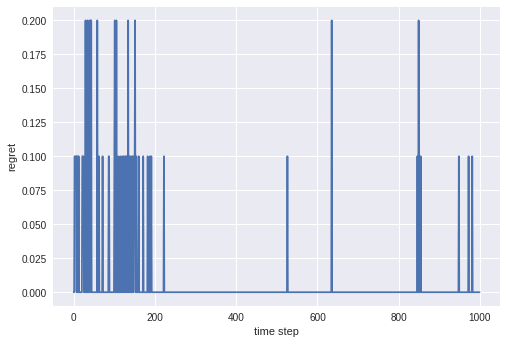

In [94]:
# plot a graph on each time step's regret
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('time step')
plt.ylabel('regret')
plt.plot(np.arange(1000), regrets)

# due to the fact that we only have done 1 simulation, this graph is only for debugging purpose

Note that the figure above is only for debugging purposes. As the agent is only tested in one iteration, the figure can't explain anything.

Actual experiment is to follow.

In [99]:
n_steps = 1000
# number of arms from 3 to 10
arms = np.arange(3,13)
# number of iterations in a specific number of arms
env_iter = 10
eps_agent_iter = 10
ts_agent_iter = 10
ucb_agent_iter = 10
regrets_eps = []
regrets_ts = []
regrets_ucb = []

for n_arm in arms:
  print('number of arms', n_arm)
  for i in range(env_iter):
    probs = np.random.rand(n_arm)
    env = SimpleBandit(probs)
    
    # expriments for epsilon greedy algorithms
    for eps in range(eps_agent_iter):
      agent = EpsilonGreedyAgent(n_arm, epsilon = 0.05 + (np.random.rand()-0.5)*0.1)
      expr = Experiment(agent, env, n_steps)
      regrets_eps.append(np.array(expr.run()))
                         
    # expriments for Thompson sampling algorithms
    for ts in range(ts_agent_iter):
      agent = TSAgent(n_arm)
      expr = Experiment(agent, env, n_steps)
      regrets_ts.append(np.array(expr.run()))
                         
    # experiments for UCB sampling algorithms
    for ucb in range(ucb_agent_iter):
      agent = UCBAgent(np.random.rand()+1, n_arm)
      expr = Experiment(agent, env, n_steps)
      regrets_ucb.append(np.array(expr.run()))  

number of arms 3
number of arms 4
number of arms 5
number of arms 6
number of arms 7
number of arms 8
number of arms 9
number of arms 10
number of arms 11
number of arms 12


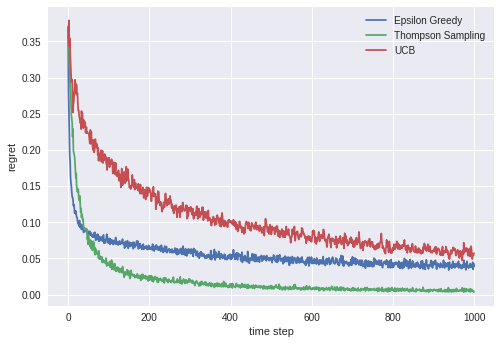

In [101]:
avg_eps = np.array(regrets_eps).sum(axis=0)/len(regrets_eps)
avg_ts = np.array(regrets_ts).sum(axis=0)/len(regrets_ts)
avg_ucb = np.array(regrets_ucb).sum(axis=0)/len(regrets_ucb)

plt.figure()
plt.xlabel('time step')
plt.ylabel('regret')
plt.plot(avg_eps, label='Epsilon Greedy')
plt.plot(avg_ts, label = 'Thompson Sampling')
plt.plot(avg_ucb, label = 'UCB')
plt.legend()
  

The figure above in general demonstrates the effectiveness of Thompson Sampling compared to $\epsilon$-greedy algorithms and UCB algorithms.

For each choice over the number of arms from 3 to 12, 10 unique environments are created with probabilities randomly initialized between \[0.1). In total there are 100 environments, and for each environment, each of the 3 algorithms are tested 10 rounds, with varying initializaton conditions, such as the $\epsilon$ value for $\epsilon$-greedy algorithm, which is randomly chosen between \[0,1]; and c for the UCB algorithm which is randomly chosen between \[1,2].

As a result, for each of the three algorithms, 1000 simulations are tested.

In [8]:
n_steps = 5000
# number of arms from 3 to 10
arms = np.arange(3,13)
# number of iterations in a specific number of arms
env_iter = 10
eps_agent_iter = 10
ts_agent_iter = 10
ucb_agent_iter = 10
regrets_eps = []
regrets_ts = []
regrets_ucb = []
  
for n_arm in arms:
  print('number of arms', n_arm)
  for i in range(env_iter):
    probs = np.random.rand(n_arm)
    env = SimpleBandit(probs)
    
    # expriments for epsilon greedy algorithms
    for eps in range(eps_agent_iter):
      agent = EpsilonGreedyAgent(n_arm, epsilon = 0.05 + (np.random.rand()-0.5)*0.1)
      expr = Experiment(agent, env, n_steps)
      regrets_eps.append(np.array(expr.run()))
                         
    # expriments for Thompson sampling algorithms
    for ts in range(ts_agent_iter):
      agent = TSAgent(n_arm)
      expr = Experiment(agent, env, n_steps)
      regrets_ts.append(np.array(expr.run()))
                         
    # experiments for UCB sampling algorithms
    for ucb in range(ucb_agent_iter):
      agent = UCBAgent(np.random.rand()+1, n_arm)
      expr = Experiment(agent, env, n_steps)
      regrets_ucb.append(np.array(expr.run()))  

number of arms 3
number of arms 4
number of arms 5
number of arms 6
number of arms 7
number of arms 8
number of arms 9
number of arms 10
number of arms 11
number of arms 12


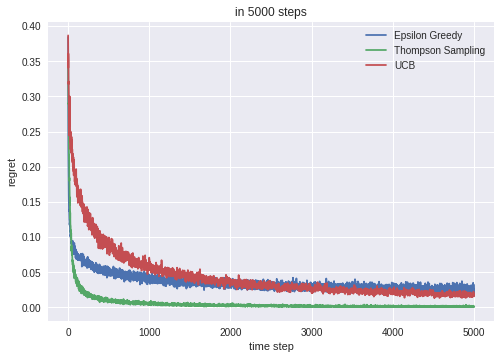

In [11]:
avg_eps = np.array(regrets_eps).sum(axis=0)/len(regrets_eps)
avg_ts = np.array(regrets_ts).sum(axis=0)/len(regrets_ts)
avg_ucb = np.array(regrets_ucb).sum(axis=0)/len(regrets_ucb)

plt.figure()
plt.title('in 5000 steps')
plt.xlabel('time step')
plt.ylabel('regret')
plt.plot(avg_eps, label='Epsilon Greedy')
plt.plot(avg_ts, label = 'Thompson Sampling')
plt.plot(avg_ucb, label = 'UCB')
plt.legend()

This figure demonstrates that in the end UCB algorithm is still better than $\epsilon$-greedy algorithm, though more steps are needed to reflect this property.

In [102]:
n_steps = 1000
# number of arms from 3 to 10
arms = np.arange(3,13)
# number of iterations in a specific number of arms
env_iter = 10
eps_agent_iter = 100
ts_agent_iter = 100
ucb_agent_iter = 100
regrets_eps = []
regrets_ts = []
regrets_ucb = []
  
for n_arm in arms:
  print('number of arms', n_arm)
  for i in range(env_iter):
    probs = np.random.rand(n_arm)
    env = SimpleBandit(probs)
    
    # expriments for epsilon greedy algorithms
    for eps in range(eps_agent_iter):
      agent = EpsilonGreedyAgent(n_arm, epsilon = 0.05 + (np.random.rand()-0.5)*0.1)
      expr = Experiment(agent, env, n_steps)
      regrets_eps.append(np.array(expr.run()))
                         
    # expriments for Thompson sampling algorithms
    for ts in range(ts_agent_iter):
      agent = TSAgent(n_arm)
      expr = Experiment(agent, env, n_steps)
      regrets_ts.append(np.array(expr.run()))
                         
    # experiments for UCB sampling algorithms
    for ucb in range(ucb_agent_iter):
      agent = UCBAgent(np.random.rand()+1, n_arm)
      expr = Experiment(agent, env, n_steps)
      regrets_ucb.append(np.array(expr.run()))  

number of arms 3
number of arms 4
number of arms 5
number of arms 6
number of arms 7
number of arms 8
number of arms 9
number of arms 10
number of arms 11
number of arms 12


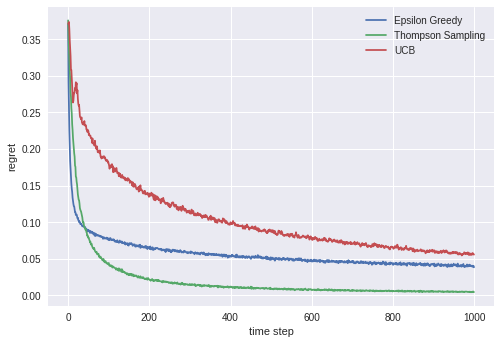

In [103]:
avg_eps = np.array(regrets_eps).sum(axis=0)/len(regrets_eps)
avg_ts = np.array(regrets_ts).sum(axis=0)/len(regrets_ts)
avg_ucb = np.array(regrets_ucb).sum(axis=0)/len(regrets_ucb)

plt.figure()
plt.xlabel('time step')
plt.ylabel('regret')
plt.plot(avg_eps, label='Epsilon Greedy')
plt.plot(avg_ts, label = 'Thompson Sampling')
plt.plot(avg_ucb, label = 'UCB')
plt.legend()

Now every algorithm is experimented 10,000 times, and the figure is consistent with the last one. Now we can conclude that in the context of Bernoulli Multi-arms bandit problem, Thompson Sampling algorithm is the best of all in terms of minimizing regret per step. UCB algorithm is slow at convergence yet in the long run it can perform better than $\epsilon$-greedy algorithm.

##A grid search over hyperparameters
This is to explain the superiority of the UCB algorithm over the $\epsilon$-greedy algorithm, which is previous figure is not fully reflected.

In [23]:
from collections import OrderedDict
eps = [0, 0.05, 0.1, 0.15, 0.2] # for eps greedy algorithm
cs = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2] # for 

n_steps = 1000
arms = np.arange(3,13)
env_iter = 10
eps_agent_iter = 10
ucb_agent_iter = 10
regrets_eps = OrderedDict({})
regrets_ucb = OrderedDict({})

for n_arm in arms:
  print('number of arms', n_arm)
  for i in range(env_iter):
    probs = np.random.rand(n_arm)
    env = SimpleBandit(probs)
    
    for e in eps:
      for _ in range(eps_agent_iter):
        agent = EpsilonGreedyAgent(n_arm, epsilon = e)
        expr = Experiment(agent, env, n_steps)
        avg_regret = np.average(expr.run())
        if e not in regrets_eps:
          regrets_eps[e] = [avg_regret]
        else:
          regrets_eps[e].append(avg_regret)
    
    for c in cs:
      for _ in range(ucb_agent_iter):
        agent = UCBAgent(c, n_arm)
        expr = Experiment(agent, env, n_steps)
        avg_regret = np.average(expr.run())
        if c not in regrets_ucb:
          regrets_ucb[c] = [avg_regret]
        else:
          regrets_ucb[c].append(avg_regret)
for e in regrets_eps:
  regrets_eps[e] = np.average(regrets_eps[e])
for c in regrets_ucb:
  regrets_ucb[c] = np.average(regrets_ucb[c])

number of arms 3
number of arms 4
number of arms 5
number of arms 6
number of arms 7
number of arms 8
number of arms 9
number of arms 10
number of arms 11
number of arms 12


In [0]:
import matplotlib.pyplot as plt

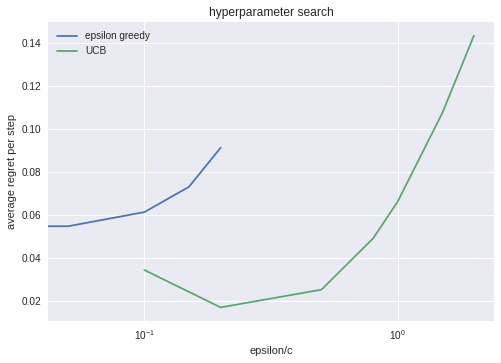

In [27]:
plt.figure()
plt.title('hyperparameter search')
plt.xlabel('epsilon/c')
plt.ylabel('average regret per step')
plt.semilogx(list(regrets_eps.keys()), list(regrets_eps.values()), label='epsilon greedy')
plt.semilogx(list(regrets_ucb.keys()), list(regrets_ucb.values()), label='UCB')
plt.legend()

With this figure, it is sufficient to conclude that under current experiment setting, choosing c value (degree of optimism) to 0.2 yields a best general response in UCB algorithm.